In [9]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
if os.getenv("SNAKEMAKE_EXECUTION"):
    # Adjust paths for Snakemake execution
    output = "./05-logistic_regression/final_pcaPN_four.png"
    db_path = "./unified-final.db"
else:
    # Adjust paths for local execution
    output = "final_pcaPN_four.png"
    db_path = "../unified-final.db"

con = sqlite3.connect(db_path)
cur = con.cursor()
df = pd.read_sql_query("SELECT * FROM prod_desc", con)

df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, 'little'))# converting binary to dec int

In [11]:
descriptors = df.columns[9:]
unidescriptors = [d for d in descriptors if len(df[d].unique()) < 2]# checking which descriptors have singular entries
print('len desc, len unidesc', len(descriptors), len(unidescriptors))
print(df.shape)
df.drop(unidescriptors, axis = 1, inplace = True)# dropping descriptors with singular value for all samples
print(df.shape)

len desc, len unidesc 211 70
(11521, 220)
(11521, 150)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time

## initially tried with non scaled descriptors

In [13]:
X = df.iloc[:, 9:]
X.shape
y = df['AB']
print(X.shape, y.shape)

(11521, 141) (11521,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)
print(y_train.value_counts())# check that training with AB = 0&!1

AB
1    4367
0    3697
Name: count, dtype: int64


In [15]:
K = []
training = []
test = []
ts = []
# scores = {}

for k in range(2, 10):
    print('running k= ', k)
    t0 = time.time()
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    ts.append(time.time()-t0)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)
    #scores[k] = [training_score, test_score]

running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9


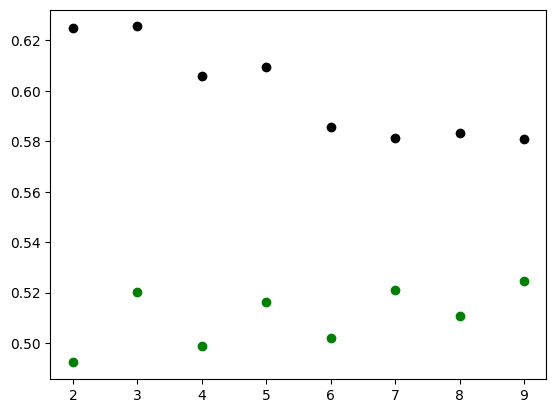

In [16]:
# choosing best K
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()

## trying with normalisation and pca of descriptors



In [17]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [18]:
ndescriptors = [d for d in X.columns if len(X[d].value_counts() ) > 1000]
# assuming this is sufficient requirement to identify non categorical descriptors
print(ndescriptors)

['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA8', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'Fra

In [19]:
dfn = df.copy()# already discarded noninforming descriptors before
dfn[ndescriptors] = normalize(dfn[ndescriptors], norm = 'l2')
df.shape, dfn.shape

((11521, 150), (11521, 150))

In [20]:
dfn.head(2)

,level_0,index,id,name,AB,description,OX,source,seq,MaxAbsEStateIndex,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
0,0.0,b'\x00\x00\x00\x00\x00\x00\x00\x00',ADAM_2177,InverPep_ADAM_2177,1,None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,1.484495e-78,...,2,0,0,1,0,0,0,3,0,5
1,NaN,b'\x981\x00\x00\x00\x00\x00\x00',P85402,UP04_GINBI,0,Unknown protein 4 (Fragment),Ginkgo biloba OX=3311,uniprot_swissprot.fasta,GDAAAQPEK,3.018380e-12,...,0,0,0,0,0,0,0,1,0,1


In [21]:
X = dfn.iloc[:, 9:]
X.shape
y = dfn['AB']
print(X.shape, y.shape)

(11521, 141) (11521,)


In [22]:
pca = PCA(n_components = 0.99)# can already retain over 0.8 of variance with one descriptor
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
Xpca = pca.transform(X)

[0.90619012 0.0330099  0.02797645 0.01205557 0.00554774 0.00411192
 0.00318173]
[32714.14877986  6243.78728447  5748.07278482  3773.28765668
  2559.66915784  2203.67997557  1938.4649606 ]


In [23]:
# taken from: https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
pca.components_.shape# 7, 141
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(n_pcs)]

initial_feature_names = dfn.columns[9:]
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {f'PC{i}': most_important_names[i].values for i in range(n_pcs)}

# build the dataframe
dfpca = pd.DataFrame(dic.items())
dfpca.columns = ['PC', 'Descriptors']
dfpca[['3', '2', '1']] = pd.DataFrame(dfpca.Descriptors.tolist(), index= dfpca.index)
dfpca.drop('Descriptors', axis=1, inplace=True)

dfpca.to_latex('final_pca_highest_components_latex.txt')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size = 0.30, random_state=0)
print(y_train.value_counts())


AB
1    4367
0    3697
Name: count, dtype: int64


In [25]:
K = []
training = []
test = []
ts = []
# scores = {}

for k in range(2, 21):
    print('running k= ', k)
    t0 = time.time()
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    ts.append(time.time()-t0)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)

running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20


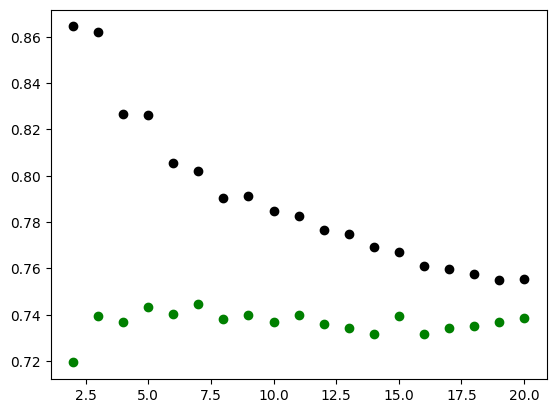

In [26]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
#plt.savefig('final_initkrange.png', dpi = 900, bbox_inches = "tight")
plt.show()

# plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


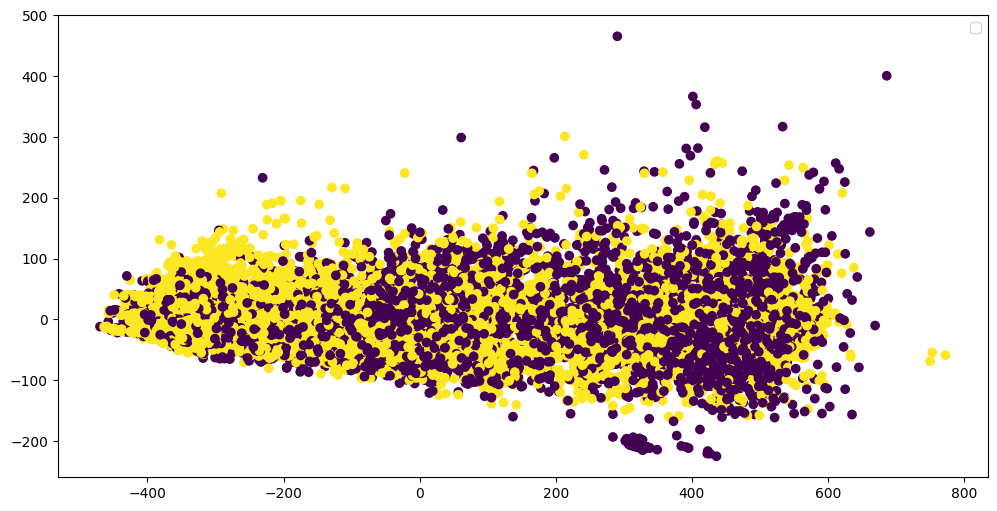

In [27]:
# first two dimensions of pca

fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(Xpca[:, 0], Xpca[:, 1], c = y[:].values)
plt.legend()

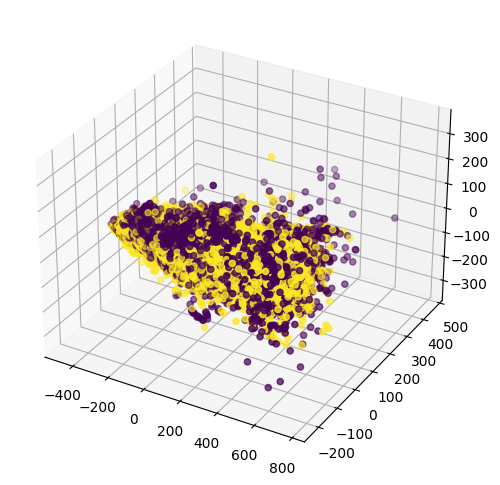

In [28]:
# first three dimensions of pca

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c = y[:].values)

In [29]:
groupex = dfn.groupby(['source'])['source'].apply(lambda x: x.index[0])# example point per group, for labeling purposes
groupex

source
APD_sequence_release_09142020.fasta    1081
BAAMPs_data.csv                        2832
DADP.html                                33
HIPdb_data.xls                          327
InverPep.fasta                            0
LAMP2.fasta                             156
dbaasp_ribosomal.txt                     86
dramp_antimicrobial.fasta              3636
uniprot_swissprot.fasta                   1
Name: source, dtype: int64

In [30]:
for n, i in zip(groupex.index, groupex.values):
  print(i, n)

1081 APD_sequence_release_09142020.fasta
2832 BAAMPs_data.csv
33 DADP.html
327 HIPdb_data.xls
0 InverPep.fasta
156 LAMP2.fasta
86 dbaasp_ribosomal.txt
3636 dramp_antimicrobial.fasta
1 uniprot_swissprot.fasta


In [31]:
ls = [i for i in groupex.values]
[i for i in groupex.index]

['APD_sequence_release_09142020.fasta',
 'BAAMPs_data.csv',
 'DADP.html',
 'HIPdb_data.xls',
 'InverPep.fasta',
 'LAMP2.fasta',
 'dbaasp_ribosomal.txt',
 'dramp_antimicrobial.fasta',
 'uniprot_swissprot.fasta']

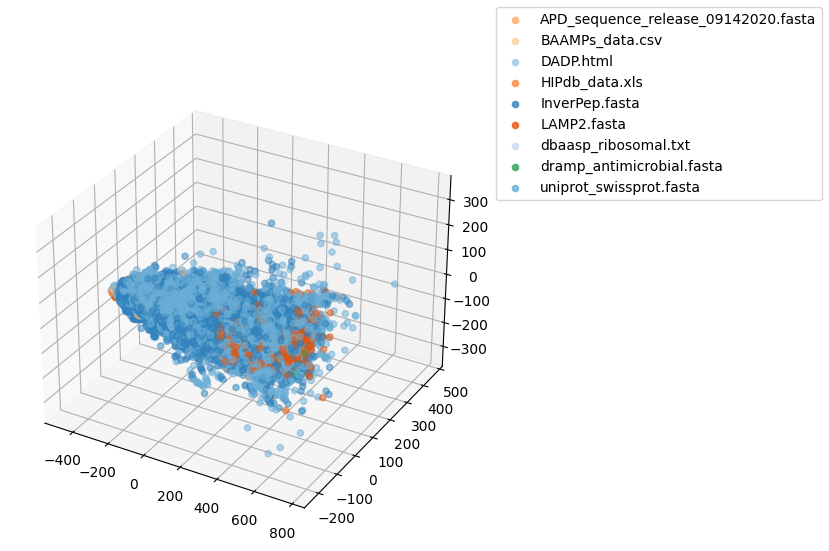

In [32]:


dcols = {n:i for i, n in enumerate( dfn['source'].unique() )}
import matplotlib as mpl
viridis = mpl.colormaps['tab20c']#(range(len(dcols)) )#.resampled(len(dcols))
lcols = [viridis(dcols[s]) for s in dfn['source'].values]


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

for n, i in zip(groupex.index, groupex.values):
  #print(n, i, lcols[i])
  ax.scatter(Xpca[i, 0], Xpca[i, 1], Xpca[i, 2], color = lcols[i], alpha = 0.8, label = n)

ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c = lcols, alpha = 0.5)

fig.legend()
#plt.savefig('final_pca3dbydataset.png', dpi = 900, bbox_inches = "tight")


# Kfold CV

In [33]:
from sklearn.model_selection import KFold

In [34]:
Xpca.shape

(11521, 7)

In [35]:
kf = KFold(n_splits=10)

outputs = {}
i = 0
for train, test in kf.split(Xpca):
  print(i)
  training = []
  testing = []
  K = []
  ts = []

  X_train = Xpca[train, :]
  X_test = Xpca[test, :]
  y_train = y[train]
  y_test = y[test]
  print( X_train.shape, X_test.shape, y_train.shape, y_test.shape )

  for k in range(2, 21):
      print('running k= ', k)
      t0 = time.time()
      clf = KNeighborsClassifier(n_neighbors = k)
      clf.fit(X_train, y_train)
      ts.append(time.time()-t0)

      training_score = clf.score(X_train, y_train)
      test_score = clf.score(X_test, y_test)

      K.append(k)
      training.append(training_score)
      testing.append(test_score)
  outputs[i] = (K, training, testing)
  i+=1



0
(10368, 7) (1153, 7) (10368,) (1153,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
1
(10369, 7) (1152, 7) (10369,) (1152,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
2
(10369, 7) (1152, 7) (10369,) (1152,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
3
(10369, 7) (1152, 7) (10369,) (1152,)
running k

In [36]:
nKs = 19
folds = 10

meantraining = np.zeros((nKs, folds))
meantesting = np.zeros((nKs, folds))
Ks = np.zeros((nKs, folds))

for f in outputs.keys():# for each fold
  K, tr, te = outputs[f]
  meantraining[:, f] = tr
  meantesting [:, f] = te
  Ks [:, f] = K

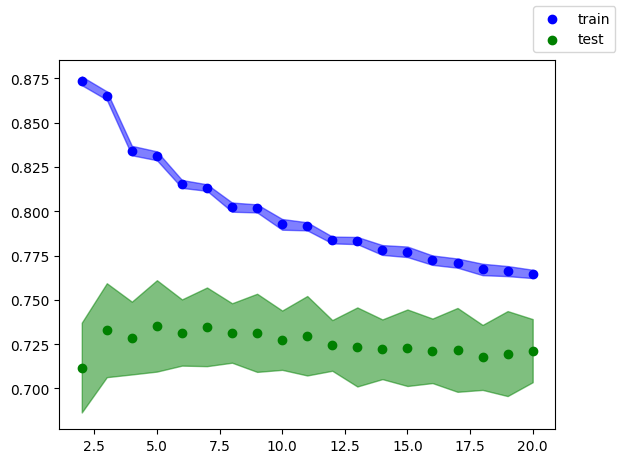

In [37]:
fig, ax = plt.subplots()

Ks = np.mean(Ks, axis = 1)

trainsd = np.std(meantraining, axis = 1)
trainmean = np.mean(meantraining, axis = 1)
ax.scatter(Ks, trainmean, color = 'b', label = 'train')
ax.fill_between(Ks, trainmean-trainsd, trainmean+trainsd, alpha = 0.5, color = 'b')

testsd = np.std(meantesting, axis = 1)
testmean = np.mean(meantesting, axis = 1)
ax.scatter(Ks, testmean, color = 'g', label = 'test')
ax.fill_between(Ks, testmean-testsd, testmean+testsd, alpha = 0.5, color = 'g')

fig.legend()
#plt.savefig('final_KrangeCV.png', dpi = 900, bbox_inches = "tight")



## go with k = 6

In [38]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size = 0.30, random_state=0)

In [39]:
k = 6
t0 = time.time()
clf = KNeighborsClassifier(n_neighbors = k)
clf.fit(X_train, y_train)
t1 = (time.time()-t0)

training_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(t1, training_score, test_score)
# report: 0.0319361686706543 0.8054315476190477 0.7405264680358693


0.006165981292724609 0.8054315476190477 0.7405264680358693


auc:  0.8130400155032896


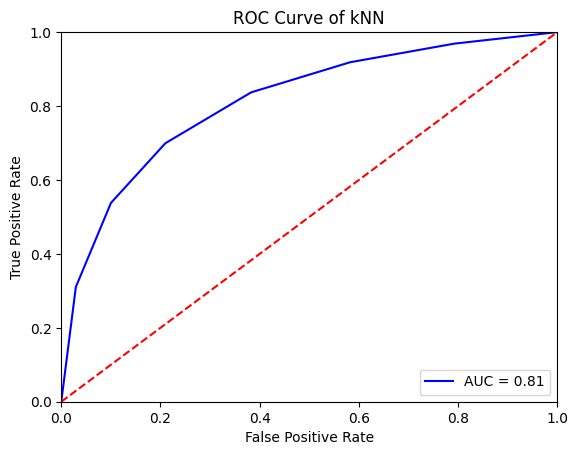

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
print('auc: ', roc_auc)

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()
#plt.savefig('final_KNN_ROC.png', dpi = 900, bbox_inches = "tight")

# report: 0.8130400155032896


In [41]:
y_pred = clf.predict(X_test)
y_pred


array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [42]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)
# report: 0.8006060606060607


0.8006060606060607

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
# report : 0.7405264680358693

0.7405264680358693

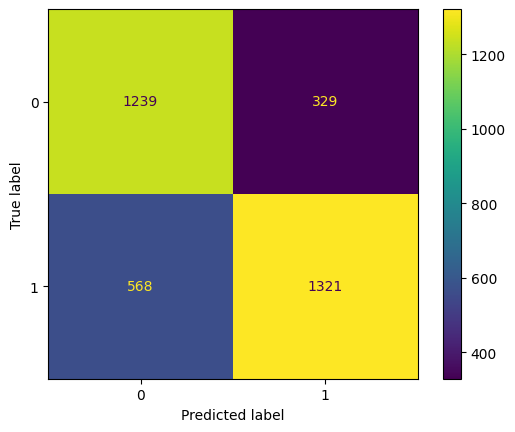

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
#plt.savefig('final_KNN_confmatrix.png', dpi = 900, bbox_inches = "tight")


# checking for correlation in features

In [45]:
X = df.iloc[:, 9:]
X.shape
y = df['AB']
print(X.shape, y.shape)

X_test, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

(11521, 141) (11521,)


In [46]:
corr = X_test.corr()


cmask = abs(corr - np.eye(len(corr ) ) ) > 0.99
cmask &= np.triu(np.ones(corr.shape[0], dtype=bool), k= 1)# because choose triu always sets first inst of corr to false
#cmask = ~cmask
#cmask = np.array(cmask, dtype = int)
cmask

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
MaxAbsEStateIndex,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MaxEStateIndex,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MinAbsEStateIndex,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MinEStateIndex,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
qed,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fr_phenol,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
fr_phenol_noOrthoHbond,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
fr_priamide,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
fr_sulfide,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
corrlines = {c: corr[cmask[c]].index.values.tolist() for c in X_test.columns if any(cmask[c]) }
# ? cmask[c].index.values.tolist() should also do
#a = [ corrlines[c]:corr[cmask[c]].index.values.tolist()) for c in list(reversed(X_test.columns))[:1] if any(cmask[c]) ]


In [48]:
redunantcols = [s for m in corrlines.values() for s in m] 
redunantcols = set(redunantcols)
redunantcols = list(redunantcols)
len(redunantcols)
# ! 93 for thr 0.9, 89 for thr 0.95, 74 for thr 0.99

74

# comparison of false positive vs true positive

In [49]:
# cm is literally 2 2 array
# fpr, tpr, are arrays
# trying to get indices of train test split without specifiying beforehand

lrange = np.arange(y.size)
X_train_ids, X_test_ids, y_train_ids, y_test_ids = train_test_split(lrange, lrange, test_size = 0.30, random_state=0)
print(sum(X_train_ids-y_train_ids))

0


In [50]:
test = dfn.copy()
test = test.iloc[X_test_ids, :]
test.drop('index', axis = 1, inplace=True)
#test.set_index('id', inplace=True)
test.head(2)

,level_0,id,name,AB,description,OX,source,seq,MaxAbsEStateIndex,MaxEStateIndex,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
10570,NaN,DBAASP2900,BPC60,1,None,alien,InverPep.fasta,KKKKLFKLLQ,1.472897e-18,1.472897e-18,...,1,0,0,0,0,0,0,1,0,5
5667,NaN,C0HLA7,MAMB4_DENVI,0,Mambaquaretin-4,Dendroaspis viridis OX=8621,uniprot_swissprot.fasta,RPSFCNLPVKPGPCSGFFSAFYYSQKTNKCHSFTYGGCRGNGNRFR...,0.000000e+00,0.000000e+00,...,9,0,6,1,0,3,3,5,0,9


In [51]:
testX = test.iloc[:, 8:]
testXpca = pca.transform(testX)
print( testXpca.shape )

(3457, 7)


In [52]:
y_pred = clf.predict(testXpca)
dpred = np.array(y_test - y_pred) # this was isseu, not indexed after subtraction

In [53]:
labels = {0:'tn', 1:'tp', -1:'fp', 2:'fn'}

tlabels = [labels[ (2*dpred[i] + y_pred[i]) ] for i,_ in enumerate(y_pred)]

test.insert(0, 'label', tlabels)
test.head(1)

,label,level_0,id,name,AB,description,OX,source,seq,MaxAbsEStateIndex,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
10570,tp,NaN,DBAASP2900,BPC60,1,None,alien,InverPep.fasta,KKKKLFKLLQ,1.472897e-18,...,1,0,0,0,0,0,0,1,0,5


In [54]:
invlabels = {v:k for k,v in zip(labels.keys(), labels.values())}

cols = [invlabels[i] for i in test['label']]

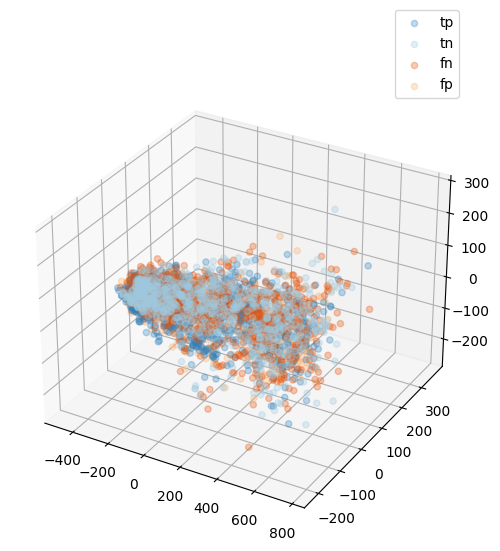

In [55]:
cmap = plt.colormaps['tab20c']#["viridis"]
mycolors = cmap(np.arange(4)*2)


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']

for i, l in enumerate(['tp', 'tn', 'fn', 'fp']):
    ids = np.where(test['label'] == l)[0] #.index.to_list() wont work as indexing from original all data
    ax.scatter(testXpca[ids, 0], testXpca[ids, 1], testXpca[ids, 2], color=mycolors[i], label=l, alpha = 0.3)

fig.legend(bbox_to_anchor=(0.7, 1), loc="upper right")
#plt.savefig('final_pcaPN_one.png', dpi = 900, bbox_inches = "tight")


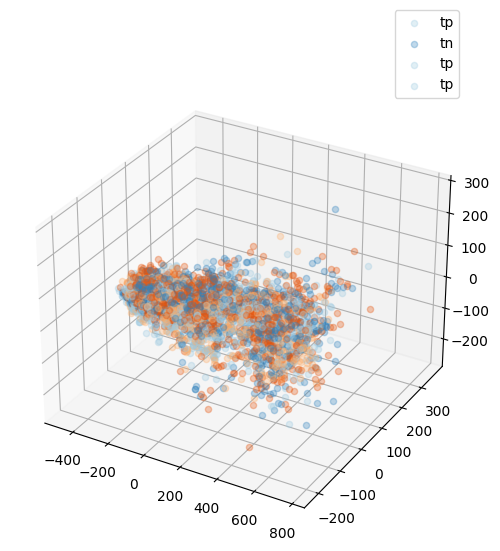

In [56]:
# redoing with scattering along line, so dont have one color ontop

cmap = plt.colormaps['tab20c']#["viridis"]
mycolors = cmap(np.arange(4)*2)


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']

for ids in range(test.shape[0]):
    type = test['label'].values[ids]
    col = invlabels[type]
    col = mycolors[col]
    if ids in labelids:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], testXpca[ids, 2], color=col, alpha = 0.3, label= type)
    else:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], testXpca[ids, 2], color=col, alpha = 0.3)


fig.legend(bbox_to_anchor=(0.7, 1), loc="upper right")
#plt.savefig('final_pcaPN_two.png', dpi = 900, bbox_inches = "tight")

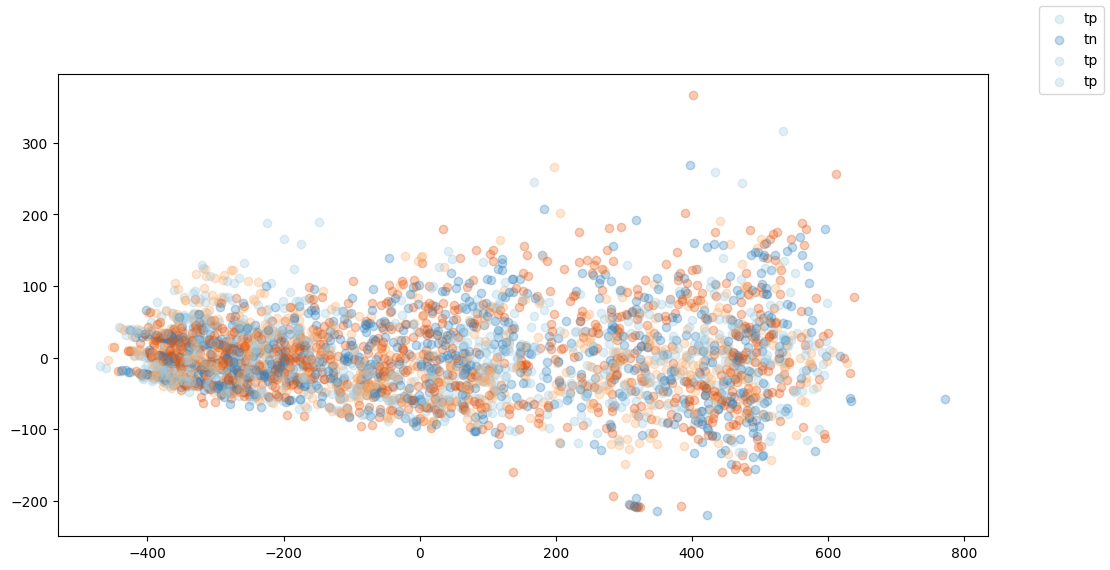

In [57]:
# redoing with scattering along line, so dont have one color ontop
#in 2d

cmap = plt.colormaps['tab20c']#["viridis"]
mycolors = cmap(np.arange(4)*2)


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']

for ids in range(test.shape[0]):
    type = test['label'].values[ids]
    col = invlabels[type]
    col = mycolors[col]
    if ids in labelids:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], color=col, alpha = 0.3, label= type)
    else:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], color=col, alpha = 0.3)


fig.legend()
#plt.savefig('final_pcaPN_Dthree.png', dpi = 900, bbox_inches = "tight")

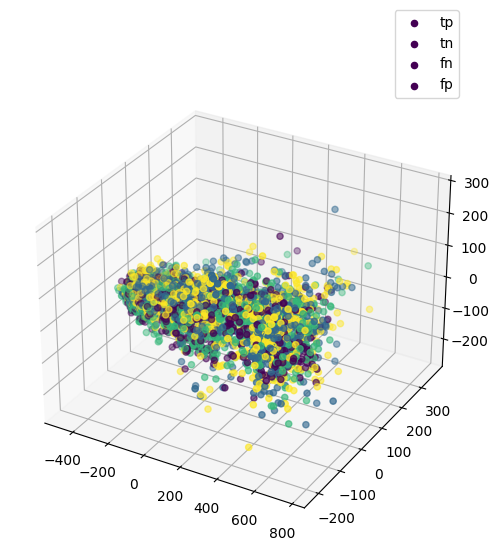

In [58]:

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(testXpca[:, 0], testXpca[:, 1], testXpca[:, 2], c=cols)

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']
for j, i in enumerate(labelids):
    ax.scatter(testXpca[i, 0], testXpca[i, 1], testXpca[i, 2], c=cols[i], label = labellabels[j])

fig.legend(bbox_to_anchor=(0.7, 1), loc="upper right")
plt.savefig(output, dpi = 900, bbox_inches = "tight")

In [59]:
# checking difference pca component

tp = test[test.label == 'tp']
fp = test[test.label == 'fp']
tn = test[test.label == 'tn']
fn = test[test.label == 'fn']

p = pd.concat((tp, fp))
n = pd.concat((tn, fn))


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# predicted positively but true/false
rf = RandomForestClassifier(random_state =0)

rf.fit(p.iloc[:, 9:], p['AB'])# had to add label to col=0, else 


RandomForestClassifier(random_state=0)

In [61]:
y_pred = rf.predict(p.iloc[:, 9:])
accuracy_score(p['AB'], y_pred)

1.0

In [62]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [63]:
pd.Series(rf.feature_importances_, index=p.columns[9:]).sort_values(ascending=False)

SMR_VSA4            0.027949
SlogP_VSA4          0.027699
HeavyAtomCount      0.027149
fr_unbrch_alkane    0.026982
EState_VSA9         0.025675
                      ...   
Chi1v               0.000000
SMR_VSA10           0.000000
Chi2v               0.000000
Chi3n               0.000000
MolLogP             0.000000
Length: 141, dtype: float64

In [64]:
# for falsesly predicting negative

rf = RandomForestClassifier()
rf.fit(n.iloc[:, 9:], n['AB'])

y_pred = rf.predict(n.iloc[:, 9:])
accuracy_score(n['AB'], y_pred)

1.0

In [65]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [66]:
pd.Series(rf.feature_importances_, index=n.columns[9:]).sort_values(ascending=False)

SlogP_VSA4             0.030616
EState_VSA9            0.028053
SMR_VSA4               0.027601
MinAbsPartialCharge    0.025064
fr_unbrch_alkane       0.024629
                         ...   
BCUT2D_MRLOW           0.000000
AvgIpc                 0.000000
VSA_EState6            0.000000
TPSA                   0.000000
BCUT2D_CHGHI           0.000000
Length: 141, dtype: float64

: 